In [1]:
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

import numpy as np
import pandas as pd
import pandas_datareader.data as web

from pyfinance.ols import PandasRollingOLS
from talib import RSI, BBANDS, MACD, NATR, ATR

from sklearn.feature_selection import mutual_info_classif, mutual_info_regression

import matplotlib.pyplot as plt
import seaborn as sns

In [1]:
sns.set_style('whitegrid')
idx = pd.IndexSlice

NameError: name 'sns' is not defined

In [ ]:
input_folder_db = '../../data/'

stocks = ['Nasdaq', 'ES']
ticker = {'Nasdaq': 'MNQ', 'ES':'MES'}

folder_path = 'Micro_Mini_Future_'
parquet_file_name = '_Micro_Mini_Future_'

years_filter = [2020, 2021]


dfs = []

for stock in stocks:
    for year in years_filter:

        file_name = os.path.join(input_folder_db, f'{folder_path}{stock}', f'{year}{parquet_file_name}{stock}.parquet'  )

        df = pd.read_parquet(file_name)

        df['ticker'] = ticker[stock]

        dfs.append(df)

        del df

data = pd.concat(dfs, ignore_index = True)

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1021933 entries, 0 to 1021932
Data columns (total 13 columns):
 #   Column  Non-Null Count    Dtype         
---  ------  --------------    -----         
 0   Date    1021933 non-null  datetime64[ns]
 1   Time    1021933 non-null  object        
 2   Open    1021933 non-null  float64       
 3   High    1021933 non-null  float64       
 4   Low     1021933 non-null  float64       
 5   Close   1021933 non-null  float64       
 6   Vol     1021933 non-null  int64         
 7   year    1021933 non-null  int64         
 8   month   1021933 non-null  int64         
 9   day     1021933 non-null  int64         
 10  hour    1021933 non-null  object        
 11  minute  1021933 non-null  object        
 12  ticker  1021933 non-null  object        
dtypes: datetime64[ns](1), float64(4), int64(4), object(4)
memory usage: 101.4+ MB


In [6]:
data.drop(columns = ['OI'], inplace= True)

## Compute Relative Strength Index (RSI)

In [10]:
data['rsi'] = data.groupby('ticker').Close.apply(RSI)

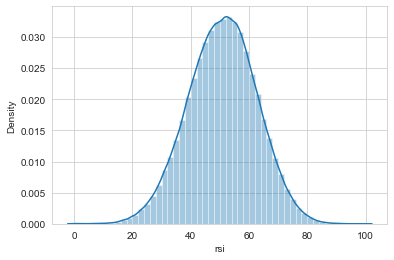

In [11]:
sns.distplot(data.rsi)

## Calculate Bollinger Bands

In [12]:
def compute_bb(close):
    high, mid, low = BBANDS(np.log1p(close), timeperiod=20)
    return pd.DataFrame({'bb_high': high,
                         'bb_mid': mid,
                         'bb_low': low}, index=close.index)

In [13]:
data = (data.join(data
                      .groupby('ticker')
                      .Close
                      .apply(compute_bb)))

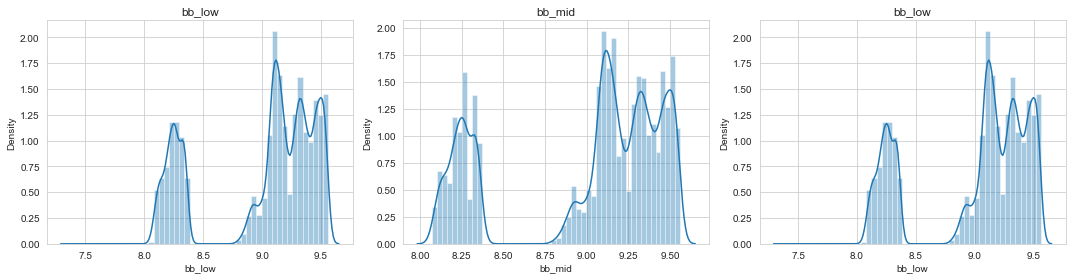

In [14]:
fig, axes = plt.subplots(ncols=3, figsize=(15,4))
for i, col in enumerate(['bb_low', 'bb_mid', 'bb_low']):
    sns.distplot(data[col], ax=axes[i])
    axes[i].set_title(col);
fig.tight_layout();

In [15]:
data['bb_up'] = data.bb_high.sub(np.log1p(data.Close))
data['bb_down'] = np.log1p(data.Close).sub(data.bb_low)

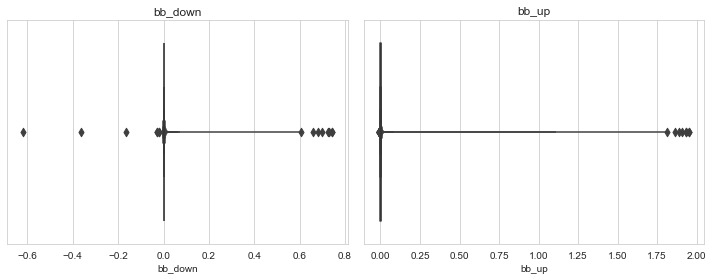

In [16]:
fig, axes = plt.subplots(ncols=2, figsize=(10,4))
for i, col in enumerate(['bb_down', 'bb_up']):
    sns.boxenplot(data[col], ax=axes[i])
    axes[i].set_title(col);
fig.tight_layout();

## Compute Average True Range

In [17]:
by_ticker = data.groupby('ticker', group_keys=False)

In [18]:
def compute_atr(stock_data):
    atr = ATR(stock_data.High, 
              stock_data.Low, 
              stock_data.Close, 
              timeperiod=14)

    # After calculating Average True Range
    # Apply Normalization z = x - mean(x) / std(x)
    return atr.sub(atr.mean()).div(atr.std())

In [19]:
data['atr'] = by_ticker.apply(compute_atr)

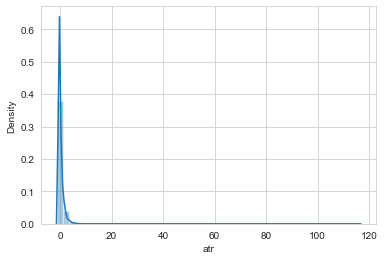

In [20]:
sns.distplot(data.atr);

In [21]:
data['natr'] = by_ticker.apply(lambda x: NATR(high=x.High, low=x.Low, close=x.Close))

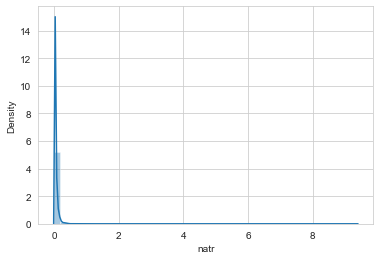

In [22]:
sns.distplot(data.natr[data.natr<10]);

## Compute Moving Average Convergence/Divergence

In [23]:
def compute_macd(close):
    macd = MACD(close)[0]
    return macd.sub(macd.mean()).div(macd.std())

data['macd'] = data.groupby('ticker').Close.apply(compute_macd)

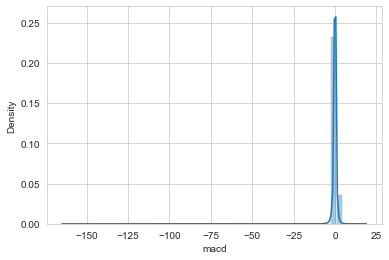

In [24]:
sns.distplot(data.macd);

## Compute dollar volume to determine universe

In [25]:
data['dollar_volume'] = (data.loc[:, 'Close']
                           .mul(data.loc[:, 'Vol'], axis=0))

data.dollar_volume /= 1e6

In [26]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1021933 entries, 0 to 1021932
Data columns (total 23 columns):
 #   Column         Non-Null Count    Dtype         
---  ------         --------------    -----         
 0   Date           1021933 non-null  datetime64[ns]
 1   Time           1021933 non-null  object        
 2   Open           1021933 non-null  float64       
 3   High           1021933 non-null  float64       
 4   Low            1021933 non-null  float64       
 5   Close          1021933 non-null  float64       
 6   Vol            1021933 non-null  int64         
 7   year           1021933 non-null  int64         
 8   month          1021933 non-null  int64         
 9   day            1021933 non-null  int64         
 10  hour           1021933 non-null  object        
 11  minute         1021933 non-null  object        
 12  ticker         1021933 non-null  object        
 13  rsi            1021905 non-null  float64       
 14  bb_high        1021895 non-null  f

In [28]:
output_location = os.path.join(input_folder_db, 'Experiments',  'ES_NQ', '2020_2021_ES_NQ.parquet')

In [37]:
data.to_parquet(output_location , engine = 'fastparquet', compression= 'gzip')

##  Create Minute Return Series

To capture time series dynamics that reflect, for example, momentum patterns, we compute historical returns using the method .pct_change(n_periods), that is, returns over various monthly periods as identified by lags.

We then convert the wide result back to long format with the .stack() method, use .pipe() to apply the .clip() method to the resulting DataFrame, and winsorize returns at the [1%, 99%] levels; that is, we cap outliers at these percentiles.

Finally, we normalize returns using the geometric average. After using .swaplevel() to change the order of the MultiIndex levels, we obtain compounded monthly returns for six periods ranging from 1 to 12 months:

In [29]:
data = pd.read_parquet(output_location)

In [30]:
data['timestamp'] = pd.to_datetime(data['Date'].astype(str) + " " + data['Time'].astype(str), format = "%Y-%m-%d %H:%M")

In [31]:
data.set_index(['ticker','timestamp'], inplace = True)

In [32]:
data.columns

Index(['Date', 'Time', 'Open', 'High', 'Low', 'Close', 'Vol', 'year', 'month',
       'day', 'hour', 'minute', 'rsi', 'bb_high', 'bb_mid', 'bb_low', 'bb_up',
       'bb_down', 'atr', 'natr', 'dollar_volume', 'macd'],
      dtype='object')

In [33]:
outlier_cutoff = 0.01
lags = [1, 3, 5, 15]
returns = []

In [34]:
outlier_cutoff = 0.01
lags = [1, 3, 5, 15]
returns = []

for lag in lags:
    returns.append(data
                   .Close
                   .unstack('ticker') # Get a Matrix of the Ticker Close values, colums are the tickers
                   .sort_index() # Sort by Date
                   .pct_change(lag) # Calculate percentage change of the respective lag value
                   .stack('ticker') # Stack back to original index order
                   .pipe(lambda x: x.clip(lower=x.quantile(outlier_cutoff),
                                          upper=x.quantile(1-outlier_cutoff))) # Cutoff outliers
                   .add(1) # add 1 to the returns
                   .pow(1/lag) # apply n root for n = lag
                   .sub(1) #substract 1
                   .to_frame(f'return_{lag}m')
                   )
    
returns = pd.concat(returns, axis=1).swaplevel()
returns.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 1023158 entries, ('MES', Timestamp('2020-01-02 00:02:00')) to ('MNQ', Timestamp('2021-06-18 13:30:00'))
Data columns (total 4 columns):
 #   Column      Non-Null Count    Dtype  
---  ------      --------------    -----  
 0   return_1m   1023158 non-null  float64
 1   return_3m   1023154 non-null  float64
 2   return_5m   1023150 non-null  float64
 3   return_15m  1023130 non-null  float64
dtypes: float64(4)
memory usage: 56.1+ MB


In [35]:
returns.describe()

,return_1m,return_3m,return_5m,return_15m
count,1.023158e+06,1.023154e+06,1.023150e+06,1.023130e+06
mean,9.385391e-07,1.034114e-06,1.056025e-06,9.779765e-07
std,4.010012e-04,2.352021e-04,1.822167e-04,1.049181e-04
min,-1.509670e-03,-8.847013e-04,-6.850292e-04,-3.958268e-04
25%,-1.383792e-04,-7.989933e-05,-6.152574e-05,-3.577434e-05
50%,0.000000e+00,0.000000e+00,0.000000e+00,2.627624e-06
75%,1.447597e-04,8.656646e-05,6.844461e-05,4.190085e-05
max,1.471276e-03,8.571942e-04,6.542488e-04,3.645580e-04


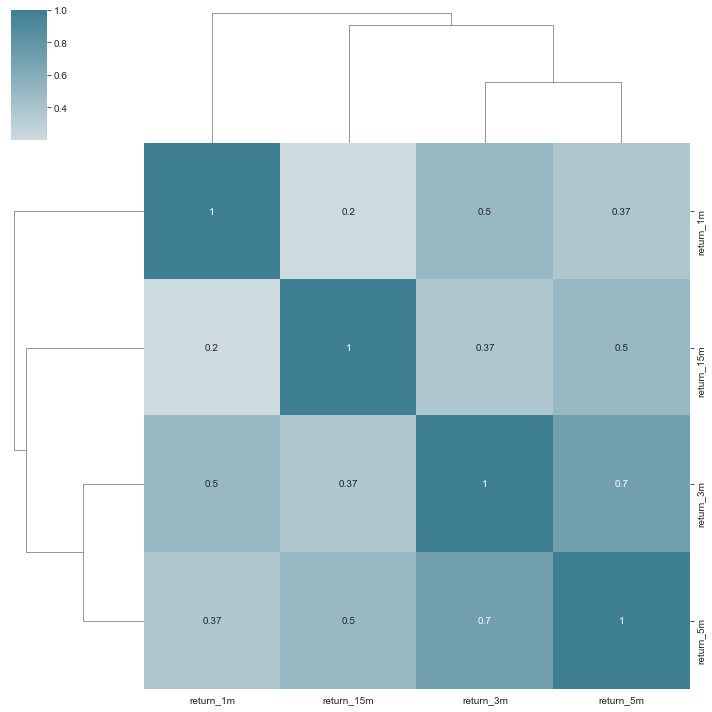

In [36]:
cmap = sns.diverging_palette(10, 220, as_cmap=True)
sns.clustermap(returns.corr('spearman'), annot=True, center=0, cmap=cmap);

In [37]:
    returns.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 1023158 entries, ('MES', Timestamp('2020-01-02 00:02:00')) to ('MNQ', Timestamp('2021-06-18 13:30:00'))
Data columns (total 4 columns):
 #   Column      Non-Null Count    Dtype  
---  ------      --------------    -----  
 0   return_1m   1023158 non-null  float64
 1   return_3m   1023154 non-null  float64
 2   return_5m   1023150 non-null  float64
 3   return_15m  1023130 non-null  float64
dtypes: float64(4)
memory usage: 56.1+ MB


In [38]:
data = data.join(returns).drop('Close', axis=1).dropna()
data.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 1021867 entries, ('MNQ', Timestamp('2020-01-02 00:34:00')) to ('MES', Timestamp('2021-06-18 13:30:00'))
Data columns (total 25 columns):
 #   Column         Non-Null Count    Dtype         
---  ------         --------------    -----         
 0   Date           1021867 non-null  datetime64[ns]
 1   Time           1021867 non-null  object        
 2   Open           1021867 non-null  float64       
 3   High           1021867 non-null  float64       
 4   Low            1021867 non-null  float64       
 5   Vol            1021867 non-null  int64         
 6   year           1021867 non-null  int64         
 7   month          1021867 non-null  int64         
 8   day            1021867 non-null  int64         
 9   hour           1021867 non-null  object        
 10  minute         1021867 non-null  object        
 11  rsi            1021867 non-null  float64       
 12  bb_high        1021867 non-null  float64       
 13  bb_mid       

## Momentum factors

We can use these results to compute momentum factors based on the difference between returns over longer periods and the most recent monthly return, as well as for the difference between 3 and 12 month returns as follows

In [39]:
for lag in [3, 5, 15]:
    data[f'momentum_{lag}'] = data[f'return_{lag}m'].sub(data.return_1m)
    if lag > 3:
        data[f'momentum_3_{lag}'] = data[f'return_{lag}m'].sub(data.return_3m)

In [40]:
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 1021867 entries, ('MNQ', Timestamp('2020-01-02 00:34:00')) to ('MES', Timestamp('2021-06-18 13:30:00'))
Data columns (total 30 columns):
 #   Column         Non-Null Count    Dtype         
---  ------         --------------    -----         
 0   Date           1021867 non-null  datetime64[ns]
 1   Time           1021867 non-null  object        
 2   Open           1021867 non-null  float64       
 3   High           1021867 non-null  float64       
 4   Low            1021867 non-null  float64       
 5   Vol            1021867 non-null  int64         
 6   year           1021867 non-null  int64         
 7   month          1021867 non-null  int64         
 8   day            1021867 non-null  int64         
 9   hour           1021867 non-null  object        
 10  minute         1021867 non-null  object        
 11  rsi            1021867 non-null  float64       
 12  bb_high        1021867 non-null  float64       
 13  bb_mid       

## Target: Holding Period Returns

To compute returns for our one-month target holding period, we use the returns computed previously and shift them back to align them with the current financial features.

In [42]:
data.head()

Date   Time     Open     High      Low  Vol  \
ticker timestamp                                                               
MNQ    2020-01-02 00:34:00 2020-01-02  00:34  8756.00  8756.00  8755.00    3   
       2020-01-02 00:35:00 2020-01-02  00:35  8754.75  8755.00  8754.25   11   
       2020-01-02 00:36:00 2020-01-02  00:36  8754.50  8754.50  8754.00    3   
       2020-01-02 00:37:00 2020-01-02  00:37  8754.00  8754.25  8753.50   20   
       2020-01-02 00:38:00 2020-01-02  00:38  8753.75  8753.75  8751.00   55   

                            year  month  day hour  ...      macd  return_1m  \
ticker timestamp                                   ...                        
MNQ    2020-01-02 00:34:00  2020      1    2   00  ...  0.328374  -0.000143   
       2020-01-02 00:35:00  2020      1    2   00  ...  0.282972  -0.000057   
       2020-01-02 00:36:00  2020      1    2   00  ...  0.237133  -0.000057   
       2020-01-02 00:37:00  2020      1    2   00  ...  0.194923  -0.000029   
       2020-01-02 00:38:00  2020      1    2   00  ...  0.142241  -0.000143   

                            return_3m  return_5m  return_15m  momentum_3  \
ticker timestamp                                                           
MNQ    2020-01-02 00:34:00  -0.000029  -0.000057   -0.000011    0.000114   
       2020-01-02 00:35:00  -0.000067  -0.000063   -0.000011   -0.000010   
       2020-01-02 00:36:00  -0.000086  -0.000040   -0.000032   -0.000029   
       2020-01-02 00:37:00  -0.000048  -0.000057   -0.000025   -0.000019   
       2020-01-02 00:38:00  -0.000076  -0.000086   -0.000025    0.000067   

                            momentum_5  momentum_3_5  momentum_15  \
ticker timestamp                                                    
MNQ    2020-01-02 00:34:00    0.000086     -0.000029     0.000131   
       2020-01-02 00:35:00   -0.000006      0.000004     0.000046   
       2020-01-02 00:36:00    0.000017      0.000046     0.000025   
       2020-01-02 00:37:00   -0.000029     -0.000010     0.000004   
       2020-01-02 00:38:00    0.000057     -0.000010     0.000118   

                            momentum_3_15  
ticker timestamp                           
MNQ    2020-01-02 00:34:00       0.000017  
       2020-01-02 00:35:00       0.000055  
       2020-01-02 00:36:00       0.000053  
       2020-01-02 00:37:00       0.000023  
       2020-01-02 00:38:00       0.000051  

[5 rows x 30 columns]

In [43]:
data['target'] = data.groupby('ticker')[f'return_1m'].shift(-1)

In [44]:
data = data.dropna()

## Data Storage

In [46]:
output_location = os.path.join(input_folder_db, 'Experiments',  'ES_NQ', 'Feature_Engineering_2020_2021_ES_NQ.parquet')

data.to_parquet(output_location , engine = 'fastparquet', compression = 'gzip')

## Evaluate Mutual Information

In [4]:
file_name = r'..\..\data\Experiments\ES_NQ\Feature_Engineering_2020_2021_ES_NQ.parquet'
data = pd.read_parquet(file_name).reset_index().drop(columns = ['ticker','timestamp','Date','Time'])

In [26]:
data.head()

,Open,High,Low,Vol,year,month,day,hour,minute,rsi,...,return_1m,return_3m,return_5m,return_15m,momentum_3,momentum_5,momentum_3_5,momentum_15,momentum_3_15,target
0,8756.00,8756.00,8755.00,3,2020,1,2,00,34,53.206210,...,-0.000143,-0.000029,-0.000057,-0.000011,0.000114,0.000086,-0.000029,0.000131,0.000017,-0.000057
1,8754.75,8755.00,8754.25,11,2020,1,2,00,35,51.361119,...,-0.000057,-0.000067,-0.000063,-0.000011,-0.000010,-0.000006,0.000004,0.000046,0.000055,-0.000057
2,8754.50,8754.50,8754.00,3,2020,1,2,00,36,49.512060,...,-0.000057,-0.000086,-0.000040,-0.000032,-0.000029,0.000017,0.000046,0.000025,0.000053,-0.000029
3,8754.00,8754.25,8753.50,20,2020,1,2,00,37,48.570509,...,-0.000029,-0.000048,-0.000057,-0.000025,-0.000019,-0.000029,-0.000010,0.000004,0.000023,-0.000143
4,8753.75,8753.75,8751.00,55,2020,1,2,00,38,44.058997,...,-0.000143,-0.000076,-0.000086,-0.000025,0.000067,0.000057,-0.000010,0.000118,0.000051,0.000000


In [27]:
X = data.drop('target', axis=1)

mi = mutual_info_regression(X = X, y = data.target)
    
mi_reg = pd.Series(mi, index = X.columns)

mi_reg.nlargest(10)

KeyboardInterrupt: 

In [ ]:
mi = mutual_info_classif(X=X, y=(data.target>0).astype(int))

In [ ]:

mi = mi_reg.to_frame('Regression').join(mi_class.to_frame('Classification'))

mi.index = [' '.join(c.upper().split('_')) for c in mi.index]

fig, axes = plt.subplots(ncols=2, figsize=(12, 4))
for i, t in enumerate(['Regression', 'Classification']):
    mi[t].nlargest(20).sort_values().plot.barh(title=t, ax=axes[i])
    axes[i].set_xlabel('Mutual Information')
fig.suptitle('Mutual Information', fontsize=14)
sns.despine()
fig.tight_layout()
fig.subplots_adjust(top=.9)